# Rewriting Motta's Code for Qiskit and Mixed Qubit Hamiltonians

In [1]:
import numpy as np
from qiskit import execute, Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram, plot_state_qsphere

aer_sim = Aer.get_backend('aer_simulator')

import matplotlib.pyplot as plt
%matplotlib inline

import time

# Pauli Poducts

In [2]:
pauli_prod = [ np.zeros([4,4],dtype=int), np.zeros([4,4],dtype=complex) ]

pauli_prod[0][0,:]=[0,1,2,3]
pauli_prod[0][1,:]=[1,0,3,2]
pauli_prod[0][2,:]=[2,3,0,1]
pauli_prod[0][3,:]=[3,2,1,0]

pauli_prod[1][0,:]=[1,  1,  1,  1]
pauli_prod[1][1,:]=[1,  1, 1j,-1j]
pauli_prod[1][2,:]=[1,-1j,  1, 1j]
pauli_prod[1][3,:]=[1, 1j,-1j,  1]

## Helper Functions

In [3]:
def int_to_base(x, b, num_digits):
    '''
    convert a non-negative integer x to base b and return the digits in a list
    '''
    if x < 0:
        raise ValueError('x must be non-negative')
    digits = [0] * num_digits
    for i in range(num_digits):
        digits[i] = x % b
        x = x//b
    return digits

def base_to_int(digits, b):
    '''
    convert a list of base b digits to an integer
    '''
    x = 0
    for i in range(len(digits)):
        x += digits[i] * (b**i)
    return x

def pauli_string_prod(p1,p2,nbits):
    '''
    returns the product of two nbit long pauli strings
    p1 and p2 are both nbit digit base 4 number representing the pauli string
    
    an nbit digit base 4 number representing the product, and the coefficient are returned
    '''
    pstring1 = int_to_base(p1,4,nbits)
    pstring2 = int_to_base(p2,4,nbits)
    
    c = 1+0.j
    prod = [0]*nbits
    
    for i in range(nbits):
        prod[i] = pauli_prod[0][pstring1[i], pstring2[i]]
        c      *= pauli_prod[1][pstring1[i], pstring2[i]]
    
    return base_to_int(prod,4), c

def odd_y_pauli_strings(nbits):
    '''
    returns a list of all the nbit long pauli strings with an odd number of Ys
    '''
    
    nops = 4**nbits
    odd_y = []
    for i in range(nops):
        p = int_to_base(i,4,nbits)
        num_y = 0
        # count the number of Y gates in the string
        for x in p:
            if x == 2:
                num_y += 1
        # append if odd number of Ys
        if num_y %2 == 1:
            odd_y.append(i)
    return odd_y

## Quantum Circuit Functions

In [4]:
def run_circuit(qc, backend, num_shots=1024):
    '''
    Run the circuit and return a dictionary of the measured counts

    qc:         The circuit you are running
    backend:    What backend you're running the circuit on
    num_shots:  The number of times you run the circuit for measurement statistics
    '''
    result = execute(qc, backend, shots=num_shots).result()
    return dict(result.get_counts())

def measure(qc, p, qbits, backend, num_shots=1024):
    '''
    Measures in the pauli string P basis and returns the expected value from the statistics
    assumes the quantum circuit has the same number of quantum and classial bits
    '''
    
    # <psi|I|psi> = 1 for all states
    if p == 0:
        return 1
    
    nbits = len(qbits)
    pstring = int_to_base(p, 4, nbits)

    # Stores the qubit indices that aren't acted on by I
    active = []

    for i in range(nbits):
        if pstring[i] == 0:
            # I only has +1 eigenvalues, so the measurement is +1
            continue
        elif pstring[i] == 1:
            # Apply H to rotate from X to Z basis
            qc.h(qbits[i])
        elif pstring[i] == 2:
            # Apply Rx(-pi/2) to rotate from Y to Z basis
            qc.rx(-np.pi/2, qbits[i])
        elif pstring[i] == 3:
            # Already in Z-basis
            None
        active.append( qbits[i] )

    # Add measurements to the circuit
    for bit in active:
        qc.measure(bit,bit)

    # Get the measurement statistics
    counts = run_circuit(qc, backend, num_shots=num_shots)

    expectation = 0
    for key in counts.keys():
        # Remove any spaces in the key
        k = key.replace(' ','') 
        # reverse the key to match ordering of bits
        k = k[::-1]
        sign = 1
        # Every 1 measured is a -1 eigenvalue
        for a in active:
            if k[ a ] == '1':
                sign *= -1
        expectation += sign*counts[key]

    expectation /= num_shots
    return expectation, counts

def pauli_string_exp(qc, qbits, p, theta):
    '''
    add gates to perform exp(-i theta/2 P) where P is the pauli string
    '''
    
    nbits = len(qbits)
    
    pstring = int_to_base(p,4,nbits)
    
    # stores the qubit indices that aren't I
    active = []
    # stores the corresponding gate on the active qubit
    gates  = []
    for i in range(nbits):
        if pstring[i] != 0:
            active.append(qbits[i])
            gates.append(pstring[i])
    
    nactive = len(active)
    
    # If the string is identity, the effect is to multiply by a global phase, so we can ignore it
    if nactive == 0:
        return
    # If there is only one active qubit, we can rotate it directly
    elif nactive == 1:
        if gates[0] == 1:
            qc.rx(theta, active[0])
        elif gates[0] == 2:
            qc.ry(theta, active[0])
        elif gates[0] == 3:
            qc.rz(theta, active[0])
    # Apply the rotation about the Pauli string for multiple active qubits
    else:
        # Rotate to Z basis
        for i in range(nactive):
            # Apply H to go from X to Z basis
            if gates[i] == 1:
                qc.h(active[i])
            # Apply Rx(pi/2) to go from Y to Z basis
            elif gates[i] == 2:
                qc.rx(np.pi/2, active[i])
        
        # Cascading CNOTs
        for i in range(nactive-1):
            qc.cx(active[i],active[i+1])
            
        # Rotate
        qc.rz(theta, active[-1])
        
        # Undo cascading CNOTs
        for i in range(nactive-2,-1,-1):
            qc.cx(active[i],active[i+1])
            
        # Rotate back to original basis
        for i in range(nactive):
            # Apply H to go from Z to X basis
            if gates[i] == 1:
                qc.h(active[i])
            # Apply Rx(-pi/2) to go from Z to Y basis
            elif gates[i] == 2:
                qc.rx(-np.pi/2,active[i])

## Verify these work

In [5]:
qc = QuantumCircuit(3,3)

qc.h(0)
qc.rx(np.pi/2,1)

qc.barrier()

p = 1+2*4+3*16

pauli_string_exp(qc,[0,2],1+2*4,np.pi/2)
qc.barrier()
expectation, counts = measure(qc, p, [0,1,2], aer_sim)
qc.draw()

┌───┐    ░    ┌───┐                           ┌───┐     ░    ┌───┐    »
q_0: ───┤ H ├────░────┤ H ├─────■───────────────■─────┤ H ├─────░────┤ H ├────»
     ┌──┴───┴──┐ ░    └───┘     │               │     └───┘     ░ ┌──┴───┴───┐»
q_1: ┤ Rx(π/2) ├─░──────────────┼───────────────┼───────────────░─┤ Rx(-π/2) ├»
     └─────────┘ ░ ┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐ ░ └───┬─┬────┘»
q_2: ────────────░─┤ Rx(π/2) ├┤ X ├┤ Rz(π/2) ├┤ X ├┤ Rx(-π/2) ├─░─────┤M├─────»
                 ░ └─────────┘└───┘└─────────┘└───┘└──────────┘ ░     └╥┘     »
c: 3/══════════════════════════════════════════════════════════════════╩══════»
                                                                       2      »
«     ┌─┐   
«q_0: ┤M├───
«     └╥┘┌─┐
«q_1: ─╫─┤M├
«      ║ └╥┘
«q_2: ─╫──╫─
«      ║  ║ 
«c: 3/═╩══╩═
«      0  1

0.04296875


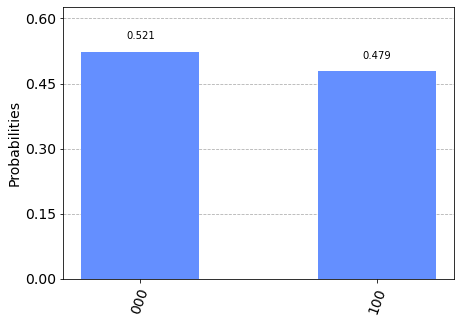

In [6]:
print(expectation)
plot_histogram(counts)

# Data Structure for Hamiltonian H and Unitary Approximations via A:

$H$ will be converted into a sum of pauli strings acting on different qubits, $ H = \sum_m \alpha_m h_m $.

We will store the superposition of these $h_m$ terms in a list. Each term hm is a list of the format:

`hm = [ [pauli string indices], [corresponding amplitude of the pauli strings], [qubit indices that the string acts on] ]`
So:
* `hm_list[i]` gives a term of the form above,
* `hm_list[i][0]` is the list of Pauli strings in the term, 
* `hm_list[i][1]` is the list the Pauli string amplitudes,
* `hm_list[i][2]` is the list of qubits that the $h_m$ term acts on.

Corresponding to each $h_m$, for each imaginary time step, we need to approximate the imaginary time evolution of $h_m$ via a Hermitian $A_m^{(\beta)} = \sum_I a_I \sigma_I $. The unitary is 
$$\exp\left(-i A_m^{(\beta)} d\beta\right) = \prod_I \exp\left(-i a_I \sigma_I d\beta\right)$$

We will store the vectors $[a_I]$ in a list of terms of the form:
`alist_term = [ [coefficients a_I], [indices of the qubits] ] ` in the order that they need to be applied. So: 
* `alist[t]` gives a term of the form above,
* `alist[t][0]` gives the list of coefficients, 
* `alist[t][1]` gives the list of qubits that the term acts on.

In [7]:
def propogate(qc, alist):
    '''
    Applies the unitaries described by each time step's A
    '''
    for t in range(len(alist)):
        active = alist[t][1]
        nbits = len(active)
        for pstring in range(1,4**nbits):
            angle = np.real(alist[t][0][pstring])
            if np.abs(angle) > 1e-5:
                pauli_string_exp(qc, active, pstring, angle)

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\bra}[1]{\langle#1|}$

# Calculating the coefficients $a_I$:

## Step 1: Calculate S

$ S_{I,J} = \bra{\psi} \sigma_I^\dagger \sigma_J \ket{\psi} = \bra{\psi} \sigma_I \sigma_J \ket{\psi} $. These terms can be found by performing tomography on the state prepared so far. All the expectation values from the measurements are stored in the list `sigma_expectation`.
We then extract the real part of this: $S \mapsto S+S^T = 2\mathrm{Re}[S]$

## Step 2: Calculate b
$$\ket{\bar\psi^\prime} = \frac{1}{\sqrt{c}} \exp\left( -d\beta\ \hat{h}[l] \right)\ket{\psi} = \exp\left(-i\ d\beta\ \hat{A}[l]\right)\ket{\psi}$$

$$ c = \bra\psi e^{-2\ d\beta\ \hat{h}[l]}\ket\psi = \bra\psi (\mathbb{1} - 2\ d\beta\ \hat{h}[l] + O(d\beta^2) \ket\psi $$
$$ c \approx 1 - 2\ d\beta\ \sum_{I\in h_m} \alpha_I \bra{\psi}\sigma_I\ket{\psi} $$

$$\ket{\Delta_0} = \frac{\ket{\bar\psi^\prime} - \ket\psi}{d\beta}, \quad \ket\Delta = -i\hat{A}[l]\ket\psi$$

$$b_I = -2 \mathrm{Im}[\bra\psi \sigma_I^\dagger \ket{\Delta_0}] \approx -2 \mathrm{Im}\left[\frac{1}{d\beta}\left(\frac{1}{\sqrt{c}} - 1\right) \bra\psi\sigma_I\ket\psi 
- \frac{1}{\sqrt{c}} \sum_{J \in h_m} \alpha_J  \bra\psi\sigma_I^\dagger\sigma_J\ket\psi
\right]$$

In [8]:
def update_alist(sigma_expectation, alist, db, delta, hm):
    '''
    updates the a term for hm given the tomography of the state prepared so far from sigma_expectation,
    returns the norm of the imaginary time evolved state
    '''
    # number of qubits that the term acts on
    nbits = len(hm[2])
    # number of pauli terms present in hm
    nterms = len(hm[0])
    
    nops = 4**nbits
    
    # Step 1: Obtain S matrix:
    # S[I,J] = <psi| sigma_I sigma_J |psi>
    
    S = np.zeros([nops,nops],dtype=complex)
    for i in range(nops):
        for j in range(nops):
            p,c_ = pauli_string_prod(i,j,nbits)
            S[i,j] = sigma_expectation[p]*c_
    
    # Step 2: Obtain b vector
    b = np.zeros(nops,dtype=complex)
    c = 1
    
    for i in range(nterms):
        c -= 2* db* hm[1][i] * sigma_expectation[hm[0][i]]
    c = np.sqrt(c)
    
    for i in range(nops):
        b[i] += ( 1/c - 1 ) * sigma_expectation[i] / db
        for j in range(nterms):
            p,c_ = pauli_string_prod(i,hm[0][j],nbits)
            b[i] -= hm[1][j] * c_ * sigma_expectation[p] / c
    b = -2*np.imag(b)
    
    # Step 3: Add regularizer to make sure the system can be solved
    dalpha = np.eye(nops)*delta
    
    # Step 4: Solve the system
    x = np.linalg.lstsq(2*np.real(S) + dalpha, -b, rcond=-1)[0]
    
    # Multiply by -2 db because the rotation gate is of the form exp(-i theta/2 P), but we want exp(i theta P)
    a_coefficients = -2*db*x
    # Append to the a coefficients
    alist.append([a_coefficients, hm[2]])
    
    return c

# Implementation of the QITE Algorithm

1. Loop for `N` imaginary time steps of size `db`:
    1. For each term $h_m$ of $H$:
        1. `propogate` using the coefficients in `alist` calculated so far
        2. Perform tomography on the active qubits in $h_m$ and store the expectations in `sigma_expectations`
        3. Add a new `alist` term from these measurement statistics
    2. Measure $\bra\psi H \ket\psi$ and store in `E[i]`

In [48]:
def measure_energy(alist, nbits, hm_list, backend, shots=1024):
    '''
    Measure the expected energy of the state evolved by alist, given the hm_list of the Hamiltonian
    '''
    Energy = 0
    
    # For each hm term
    for hm in hm_list:
        # For each pauli term in hm
        for j in range(len(hm[0])):
            qc = QuantumCircuit(nbits, nbits)
            # Get the state evolved from alist
            propogate(qc, alist)
            
            # Measure the expected value of the pauli term in this state
            expectation, counts = measure(qc, hm[0][j], hm[2], backend, num_shots=shots)
            
            # Add this with the relevant weight to the energy total
            Energy += hm[1][j] * expectation
    return Energy

def tomography(alist, qbits, nbits, backend, shots=1024):
    '''
    Perform tomography on the state evolved by alist
    '''
    nactive = len(qbits)
    nops = 4**nactive
    
    sigma_expectation = np.zeros(nops,dtype=float)
    
    # <psi|I|psi> = 1 for all states
    sigma_expectation[0] = 1
    
    for i in range(1,nops):
        qc = QuantumCircuit(nbits,nbits)
        # Get the state evolved from alist
        propogate(qc,alist)
        
        # measure the expectation of the pauli string indexed by i
        sigma_expectation[i],counts = measure(qc, i, qbits, backend, num_shots=shots)
    return sigma_expectation

def qite_step(alist, db, delta, nbits, hm_list, backend, shots=1024):
    '''
    performs one imaginary time step of size db in the QITE
    '''
    for hm in hm_list:
        # peform tomography on the active qubits in hm
        sigma_expectation = tomography(alist, hm[2], nbits, backend, shots)
        # obtain the next alist term corresponding to hm
        norm = update_alist(sigma_expectation, alist, db, delta, hm)
    return alist

import time

def log_alist(db, delta, N, nbits, hm_list, alist, file_name='hm-alist'):
    logging = []
    logging.append(db)
    logging.append(delta)
    logging.append(N)
    logging.append(nbits)
    logging.append(hm_list)
    logging.append(alist)
    
    np.save(file_name+'.npy',np.asarray(logging,dtype=object))
    
        

def qite(db, delta, N, nbits, hm_list, backend, shots=1024, details=False, log=False, log_file = 'hm-alist'):
    '''
    Performs the QITE algorithm with: 
        db: a time step,
        delta: a regularization,
        N: number of total iterations (time steps)
        nbits: number of qubits in the whole system
        hm_list: list of local terms in the Hamiltonian
        backend: the backend that the quantum circuit will run on
        shots: the number of shots for each circuit run
        details: flag to show details while the algorithm runs
    '''
    # stores the mean energy for each time step
    E = np.zeros(N+1,dtype=float)
    # stores the iteration times
    times = np.zeros(N+1,dtype=float)
    
    alist = []
    
    E[0] = measure_energy(alist, nbits, hm_list, backend, shots)
    
    start = 0
    end = 0
    if details:
        print('Starting QITE Loop')
    
    for i in range(1,N+1):
        if details:
            print('i={}:'.format(i), end='  ', flush=True)
            start = time.time()

        # correction_matrix = estimate_assignment_probs()
        alist = qite_step(alist, db, delta, nbits, hm_list, backend, shots)
        # Record the energy of the system after the QITE step
        E[i] = measure_energy(alist, nbits, hm_list, backend, shots)

        if details:
            end = time.time()
            duration = end-start
            times[i] = duration
            print('Execution time: {:.2f} seconds'.format(duration))

    if log:
        log_alist(db, delta, N, nbits, hm_list, alist, log_file)
    return E,times

Helper functions that convert the `hm_list` description into a Hamiltonian matrix and returns the minimum eigenvalue of the matrix with numpy

In [49]:
sigma_matrices = np.zeros([4,2,2], dtype=complex)
# sigma_matrices is a list of 4x4 matrices, sigma_matrix[0] is I, etc up to Z
sigma_matrices[0] = np.array([[1,0],[0,1]])
sigma_matrices[1] = np.array([[0,1],[1,0]])
sigma_matrices[2] = np.array([[0,-1j],[1j,0]])
sigma_matrices[3] = np.array([[1,0],[0,-1]])
# print(sigma_matrices)

def get_h_matrix(hm_list, nbits):
    num_basis = 2**nbits
    h_mat = np.zeros([num_basis,num_basis],dtype=complex)
    
    for hm in hm_list:
        active = hm[2]
        nactive = len(active)
        nterms = len(hm[0])
        # Loop through the Pauli terms in hm
        for i in range(nterms):
            full_pauli_str = [0] * nbits
            partial_pauli_str = int_to_base(hm[0][i],4,nactive)
            for j in range(len(active)):
                full_pauli_str[active[j]] = partial_pauli_str[j]
            
            # The matrix for the term is a tensor product of the corresponding Pauli matrices
            term_matrix = sigma_matrices[full_pauli_str[0]]
            for j in range(1,nbits):
                term_matrix = np.kron(term_matrix, sigma_matrices[full_pauli_str[j]])
            # Scale by the coefficient of the term
            term_matrix *= hm[1][i]
            
            # Add the term to the final matrix
            h_mat += term_matrix
    return h_mat

def get_spectrum(hm_list, nbits):
    '''
    returns the spectrum of the Hamiltonian
    '''
    h_mat = get_h_matrix(hm_list, nbits)
    return np.linalg.eig(h_mat)

def get_gs(hm_list, nbits):
    '''
    returns the ground state energy and the ground state vector of the Hamiltonian
    '''
    w,v = get_spectrum(hm_list,nbits)
    i = np.argmin(w)
    return w[i],v[:,i]

# hm_list = []
# hm = [ [3+1*4], [np.sqrt(0.5)], [0,1] ]
# hm_list.append(hm)
# hm = [ [1,3], [0.5, 0.5], [1]]
# hm_list.append(hm)

# nbits = 2

# print(get_gs(hm_list,nbits))

In [73]:
N = 30
shots = 1000
db = 0.05
delta = 0.1

nbits = 2

hm_list = []
hm = [ [3+1*4], [np.sqrt(0.5)], [0,1] ]
hm_list.append(hm)
hm = [ [1,3], [0.5, 0.5], [1]]
hm_list.append(hm)

backend = aer_sim

E,times = qite(db, delta, N, nbits, hm_list, backend, shots, details=True, log=True, log_file='./qite_logs/test/run4')

Starting QITE Loop
i=1:  Execution time: 0.48 seconds
i=2:  Execution time: 2.76 seconds
i=3:  Execution time: 4.52 seconds
i=4:  Execution time: 7.00 seconds
i=5:  Execution time: 9.22 seconds
i=6:  Execution time: 10.94 seconds
i=7:  Execution time: 13.75 seconds
i=8:  Execution time: 14.52 seconds
i=9:  Execution time: 16.59 seconds
i=10:  Execution time: 19.33 seconds
i=11:  Execution time: 20.66 seconds
i=12:  Execution time: 23.28 seconds
i=13:  Execution time: 25.18 seconds
i=14:  Execution time: 27.91 seconds
i=15:  Execution time: 30.24 seconds
i=16:  Execution time: 31.09 seconds
i=17:  Execution time: 34.56 seconds
i=18:  Execution time: 33.37 seconds
i=19:  Execution time: 36.56 seconds
i=20:  Execution time: 38.73 seconds
i=21:  Execution time: 40.47 seconds
i=22:  Execution time: 42.80 seconds
i=23:  Execution time: 46.03 seconds
i=24:  Execution time: 47.16 seconds
i=25:  Execution time: 49.06 seconds
i=26:  Execution time: 50.48 seconds
i=27:  Execution time: 52.62 seco

-0.5491585130146568


C:\Users\CMP3KUMARS\Anaconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


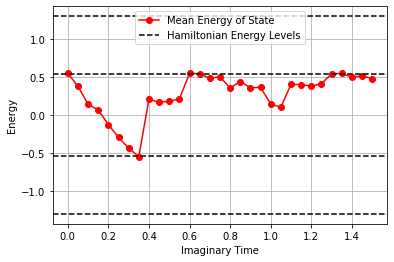

In [74]:
p1, = plt.plot(np.arange(0,N+1)*db, E, 'ro-')
plt.grid()
plt.xlabel('Imaginary Time')
plt.ylabel('Energy')

w,v = get_spectrum(hm_list,nbits)
spectrum_lines = []
for energy_level in w:
    p2 = plt.axhline(y=energy_level, color='k', linestyle='--')
    spectrum_lines.append(p)

# gs_energy, gs = get_gs(hm_list, nbits)

# plt.axhline(y=gs_energy, color='k', linestyle='-')

print(np.min(E))

# l = ax.legend([p1, tuple(spectrum_lines)], ['Mean Energy of State', 'Energy Levels of Hamiltonian'],
#              handler_map = {tuple: HandlerTuple(ndivide=None)})

plt.legend((p1,p2), ('Mean Energy of State', 'Hamiltonian Energy Levels'), loc='upper center')
plt.savefig('./figs/test/run4.png')
plt.show()

total time = 14.99 minutes
y=1.99x+(-0.86)


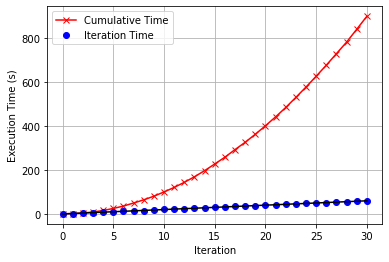

In [75]:
x = np.arange(0,N+1)

cumulative_time = np.zeros(N+1,dtype=float)
for i in range(1,N+1):
    cumulative_time[i] = cumulative_time[i-1] + times[i]

print('total time = {:.2f} minutes'.format(np.sum(times)/60))
plt.plot(x,cumulative_time,'rx-', label='Cumulative Time')
plt.plot(x,times,'bo', label='Iteration Time')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Execution Time (s)')

m,b = np.polyfit(x,times,1)
plt.plot(x, m*x+b, 'k-')

print('y={:.2f}x+({:.2f})'.format(m,b))

plt.legend(loc='best')

plt.show()


# Using the log files to determine the state evolution

In some runs of the program, I found that after reaching a mean energy close to the first excited state of the Hamiltonian, the energy of time evolved state jumps up and does not converge to ground state energy afterwards. The only difference between runs that properly converge and those that do not are the measurement statistics obtained in the run. This leads me to believe that these runs happen to have measurements that evolve the state into one that has very small component of the ground state in the superposition. Such a state will not converge to the ground state in the short term.

I've added logging functionality to the qite program so that at the end of the execution, it stores `[db, delta, N, nbits, hm_list, alist]` in `hm-alist.npy` (or other file name that's passed into `qite()`)

$\newcommand{\braket}[2]{\langle{#1}|{#2}\rangle}$

From the logged data, I will generate the circuit at each time step and evolve using a state vector simulator and plot the fidelity
$$ |\braket{\phi_{gs}}{\psi(\beta)}|^2 $$
for each time step in the run. For runs that did not converge to the gound state, we should expect the fidelity to converge towards zero when the energy reaches the first excited state.

If this is indeed the case, we can use this to identify signatures of bad runs and cull or correct them before wasting more computing resources.

Next I will calculate the theoretical measurement statistics for each time step and make a circuit based on that, and compare the evolution of the theoretical statistics with that of the simulation.

In [113]:
x = np.load('./qite_logs/test/run3.npy',allow_pickle=True)
db = x[0]
delta = x[1]
N = x[2]
nbits = x[3]
hm_list = x[4]
alist = x[5]

In [114]:
sv_sim = Aer.get_backend('statevector_simulator')

In [115]:
nterms = len(hm_list)
from qiskit.quantum_info import Statevector

psi0 = Statevector.from_label('00')

statevectors = np.zeros([N+1, 2**nbits],dtype=complex)

statevectors[0] = psi0.data

# print(statevectors)

for i in range(1,N+1):
    qc = QuantumCircuit(nbits)
    propogate(qc, alist[0:nterms*i])
    psi_b = psi0.evolve(qc)
    statevectors[i] = psi_b.data

In [118]:
e_gs,phi_gs = get_gs(hm_list,nbits)

fidelities = np.abs(np.matmul(np.conj(statevectors), phi_gs.T))**2
print(fidelities)

[0.30865828 0.31126532 0.30645949 0.29960856 0.29344326 0.2842114
 0.27409634 0.26163928 0.24745183 0.23274256 0.21594201 0.20397081
 0.1909249  0.18198864 0.17380692 0.16637088 0.19813932 0.18577942
 0.15651302 0.14896158 0.14193444 0.13633552 0.12891225 0.11049281
 0.10574018 0.10135582 0.09745801 0.09715699 0.17418107 0.15502523
 0.15083596]


In [119]:
print(phi_gs)

[-0.55557023+0.j  0.83146961+0.j  0.        +0.j  0.        +0.j]


In [121]:
print(statevectors[N])

[ 0.57872062-0.10210464j -0.07180789+0.02099146j -0.74479326+0.06139382j
  0.20323992+0.22196263j]


In [125]:
dot = np.vdot(statevectors[-2],phi_gs)
print(dot, np.abs(dot))

(-0.3877462136190626-0.06839670157027818j) 0.39373244082957326


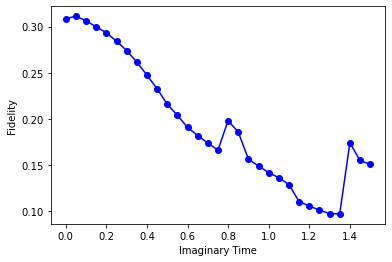

In [120]:
plt.plot(np.arange(0,N+1)*db, fidelities, 'bo-', label='Fidelity to ground state')
plt.xlabel('Imaginary Time')
plt.ylabel('Fidelity')

plt.show()